In [1]:
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb

In [2]:
%%writefile xgb_tuning.py

import numpy as np
from mpi4py import MPI
import pandas as pd
import time
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


X = pd.read_csv('final_metadata_2.csv')
y = X['Y']
X = X.drop(columns = ['Y','score','id'])
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

min_child_weight= [1, 5, 10]
max_depth= [3, 4, 5, 6, 7]
n_estimators = [100,200,300]
learning_rate=[0.1,0.01,0.001]


param_grid_prod = list(product(learning_rate,n_estimators,max_depth,min_child_weight))
num_params = len(param_grid_prod)
rank_size = num_params // size

def xgb_model (X_train,y_train,X_test,y_test,param):
    """
    Args:
    parm = [max_depth, n_estimators, 'min_samples_split', 'max_features']
    
    """

    model = xgb.XGBClassifier(learning_rate=param[0], n_estimators=param[1],max_depth = param[2], min_child_weight=param[3],objective='binary:logistic',
                        silent=True, nthread=1)

    
    model.fit(X_train, y_train,eval_metric ='auc')
    y_test_prob = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_test_prob)
    
    print(param, auc)
    
    return auc



start = time.time()
if rank == (size-1):
    sub_param_grid = param_grid_prod[rank*rank_size:num_params]
    auc_result = []

    for param in sub_param_grid:
        auc = xgb_model(X_train, y_train, X_test, y_test,param)
        
        auc_result.append(auc)
    best_auc = np.max(auc_result)
    idx = np.argmax(auc_result)
    best_param = sub_param_grid[idx]
    all_best_param=comm.gather(best_param, root=0)
    all_best_auc=comm.gather(best_auc, root=0)
    print('Rank: ',rank, 'Best AUC: ', best_auc, 'Best Parameter: ',best_param)

else:
    sub_param_grid = param_grid_prod[rank*rank_size:(rank+1)*rank_size]
    auc_result = []

    
    for i in range(len(sub_param_grid)):
        auc = xgb_model(X_train, y_train, X_test, y_test,sub_param_grid[i])
        
        auc_result.append(auc)
    
    best_auc = np.max(auc_result)
    idx = np.argmax(auc_result)
    best_param = sub_param_grid[idx]
    all_best_param=comm.gather(best_param, root=0)
    all_best_auc=comm.gather(best_auc, root=0)
    print('Rank: ',rank, 'Best AUC: ', best_auc, 'Best Parameter: ',best_param)
if rank ==0:
    best_auc = np.max(all_best_auc)
    best_param = all_best_param[np.argmax(all_best_auc)]
    print("final result",best_auc,"best param",best_param)
end = time.time()
print('Rank',rank, 'takes ', end-start,'s')

Overwriting xgb_tuning.py


In [3]:
!mpirun -n 16 python3 xgb_tuning.py

--------------------------------------------------------------------------
btl_vader_single_copy_mechanism MCA variable, but CMA support is
not available due to restrictive ptrace settings.

The vader shared memory BTL will fall back on another single-copy
mechanism if one is available. This may result in lower performance.

  Local host: NarakuX
--------------------------------------------------------------------------
[NarakuX:00181] 15 more processes have sent help message help-btl-vader.txt / cma-permission-denied
[NarakuX:00181] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages
(0.01, 100, 4, 1) 0.7779831235914251
(0.001, 100, 5, 1) 0.7622031295061993
(0.001, 100, 7, 10) 0.7798112113224893
(0.1, 100, 3, 1) 0.8043938312131305
(0.1, 100, 5, 10) 0.8119143265781895
(0.1, 200, 3, 5) 0.8103013107782773
(0.01, 200, 4, 5) 0.7873378170892922
(0.01, 100, 4, 5) 0.7779455967249005
(0.1, 200, 6, 1) 0.8131574617609045
(0.001, 100, 5, 5) 0.76186259302761
(0.1, 10

# Without MPI

In [4]:
import numpy as np
from mpi4py import MPI
import pandas as pd
import time
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [5]:
X = pd.read_csv('final_metadata_2.csv')
y = X['Y']
X = X.drop(columns = ['Y','score','id'])
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

min_child_weight= [1, 5, 10]
max_depth= [3, 4, 5, 6, 7]
n_estimators = [100,200,300]
learning_rate=[0.1,0.01,0.001]


param_grid_prod = list(product(learning_rate,n_estimators,max_depth,min_child_weight))


def xgb_model (X_train,y_train,X_test,y_test,param):
    

    model = xgb.XGBClassifier(learning_rate=param[0], n_estimators=param[1],max_depth = param[2], min_child_weight=param[3],objective='binary:logistic',
                        silent=True, nthread=1)

    
    model.fit(X_train, y_train,eval_metric ='auc')
    y_test_prob = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_test_prob)
    
    print(param, auc)
    
    return auc


In [37]:
start = time.time()
auc_result = []
for param in param_grid_prod:
        auc =  xgb_model(X_train, y_train, X_test, y_test,param)
        #auc,precision,recall = rf_model(X_train, y_train, X_test, y_test,sub_param_grid[i])
        auc_result.append(auc)
best_auc = np.max(auc_result)
idx = np.argmax(auc_result)
best_param = param_grid_prod[idx]
  
print('Best AUC: ', best_auc, 'Best Parameter: ',best_param)
end = time.time()
print('takes ', end-start,'s')

(0.1, 100, 3, 1) 0.8043938312131305
(0.1, 100, 3, 5) 0.8050359918057144
(0.1, 100, 3, 10) 0.8043831261682146
(0.1, 100, 4, 1) 0.8091882111024437
(0.1, 100, 4, 5) 0.8090702424548202
(0.1, 100, 4, 10) 0.8095572391054439
(0.1, 100, 5, 1) 0.8119125147730212
(0.1, 100, 5, 5) 0.8119101937677076
(0.1, 100, 5, 10) 0.8119143265781895
(0.1, 100, 6, 1) 0.8132785685024468
(0.1, 100, 6, 5) 0.8136505096039529
(0.1, 100, 6, 10) 0.8131361700897113
(0.1, 100, 7, 1) 0.8123922405192439
(0.1, 100, 7, 5) 0.813593218666671
(0.1, 100, 7, 10) 0.8131612866829265
(0.1, 200, 3, 1) 0.8100048970843744
(0.1, 200, 3, 5) 0.8103013107782773
(0.1, 200, 3, 10) 0.8099027017993927
(0.1, 200, 4, 1) 0.8125150880147716
(0.1, 200, 4, 5) 0.8123194841077807
(0.1, 200, 4, 10) 0.8124763888037262
(0.1, 200, 5, 1) 0.8131322622746426
(0.1, 200, 5, 5) 0.813966995257073
(0.1, 200, 5, 10) 0.8132207683650197
(0.1, 200, 6, 1) 0.8131574617609045
(0.1, 200, 6, 5) 0.81426141951785
(0.1, 200, 6, 10) 0.813438859971452
(0.1, 200, 7, 1) 0.81184

In [21]:
X = pd.read_csv('final_metadata_2.csv')
X = X.drop(columns = ['Y','score','id'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [22]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=200,max_depth = 6, min_child_weight=5,objective='binary:logistic',
                        silent=True, nthread=1)
model.fit(X_train, y_train,eval_metric ='auc')


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

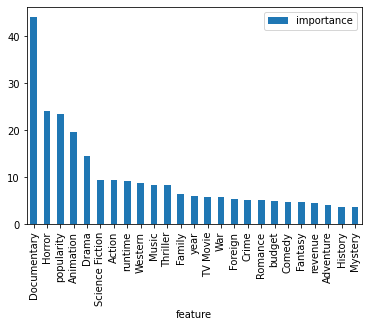

In [36]:
pd.DataFrame(model.get_booster().get_score(importance_type="gain").items(), columns=['feature','importance']).sort_values('importance', ascending=False).plot.bar(x='feature',y='importance')
